# Tracks Genre Classification

- What does each playlist set sound like? What are their defining characteristics?

- Using user-marked playlist genres as training data, can we build a model to correctly classify songs from a separate track dataset?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Read the training data

In [3]:
#genre_names = ["R&B", "Classical", "Country", "Electronic", "Hiphop","Jazz", "Pop", "Rock", "Reggae", "Rap"]
genre_names = ["folk", "rock", "hiphoprapcons", "country", "jazz"]
#["R&B", "Classical", "Country", "Electronic","Jazz", "Pop", "Rock", "Rap","Alternative","OPM","Chill"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword

    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('sample/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    track_df_list.append(tdf)
        
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


In [5]:
#check shape
playlist_df.shape, tracks_df.shape

((553, 7), (5000, 22))

In [6]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)


Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'playlist_name' 'genre']


In [7]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]


,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre


In [213]:
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(21673, 22)

In [214]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

18634

In [215]:
#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(18634, 22)

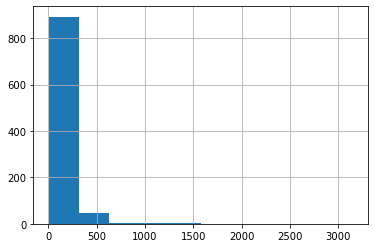

In [90]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

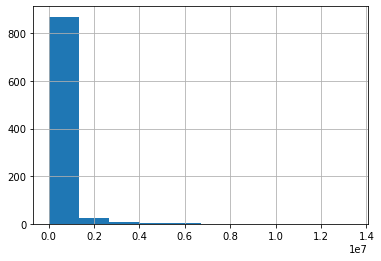

In [216]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [93]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

electronic              0.151990
classical               0.117467
chill                   0.115209
rock                    0.096493
jazz                    0.079031
rnb                     0.074916
pop                     0.071504
country                 0.062923
alternative             0.057906
opm                     0.057354
rap                     0.050228
philippine band         0.040092
acoustic philippines    0.024888
Name: genre, dtype: float64

## 2. Refine the training data

In [217]:
#get top playlists
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,40,spotify,Spotify,3186018,rnb
1,37i9dQZF1DX6VDO8a6cQME,I Love My '90s R&B,45,spotify,Spotify,2386964,rnb
2,37i9dQZF1DX2UgsUIg75Vg,Chilled R&B,50,spotify,Spotify,2030733,rnb
3,37i9dQZF1DWSfMe9z89s9B,Alternative R&B,100,spotify,Spotify,860678,rnb
4,37i9dQZF1DXbirtHQBuwCo,TrenChill K-R&B,50,spotify,Spotify,481187,rnb


In [218]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz           690
chill          649
rock           506
classical      476
pop            475
electronic     375
rnb            281
country        259
rap            229
opm            202
alternative    183
Name: genre, dtype: int64

## 3. Feature Engineering

##### Conversions/Normalizations

In [219]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [220]:
#Normalize loudness
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()


count    4325.000000
mean        0.778958
std         0.141308
min         0.000000
25%         0.724551
50%         0.821140
75%         0.876998
max         1.000000
Name: loudness, dtype: float64

In [221]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    4325.000000
mean        0.531189
std         0.134849
min         0.000000
25%         0.416790
50%         0.534591
75%         0.613710
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [222]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
playlist_name         object
genre               category
duration_mins        float64
dtype: object

In [223]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,duration_mins,genre_id
0,6nTcn8CybBcx0t7IaXEJ6O,Thank God I Found You (feat. Joe & Nas) - Make...,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,6zuCJaxmHKNKN5hMDF556U,251640,2000-04-18,55,0.608,0.760,...,0.0129,0.0,0.3320,0.366,0.770222,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,4.194000,9
1,7FWuzwapuKHTEyDJIcQOw3,Stutter (feat. Mystikal) - Double Take Remix,3zTOe1BtyTkwNvYZOxXktX,Joe,6zuCJaxmHKNKN5hMDF556U,213026,2000-04-18,55,0.767,0.759,...,0.0513,0.0,0.3100,0.677,0.412051,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,3.550433,9
2,3QE7ObGjkt1kYnhLvZPRUy,Go On Girl,21E3waRsmPlU7jZsS13rcj,Ne-Yo,52q9xNv8COtSU9phlbO5sg,261426,2007-01-01,65,0.637,0.521,...,0.1550,0.0,0.0945,0.562,0.384152,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,4.357100,9
3,6De63WRULDaa1fxOyLilnv,Stingy,7r8RF1tN2A4CiGEplkp1oP,Ginuwine,3t4OgAvvOzvXw8D2NHUeDR,259493,2003-04-08,54,0.622,0.573,...,0.2600,0.0,0.1730,0.617,0.582125,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,4.324883,9
4,08fhbfRSg7eEH0IZT7pB6a,That Girl,1goOx6gnQdUllLfSMsL4Rt,Marques Houston,4sAouJxcSwPIoT5dd6Qgj7,215960,2003-10-21,53,0.683,0.552,...,0.5480,0.0,0.2210,0.519,0.453064,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,3.599333,9


In [224]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{9: 'rnb',
 2: 'classical',
 3: 'country',
 4: 'electronic',
 5: 'jazz',
 7: 'pop',
 10: 'rock',
 8: 'rap',
 0: 'alternative',
 6: 'opm',
 1: 'chill'}

## 4. Train a KNN model

In [225]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report

In [ ]:
#test plot for a genre and 2 predictors

#fig = plt.figure()
#ax= fig.add_subplot(111)

#colormaps = ['Reds','Blues']
#genre = 'pop'
#label = ["not "+genre,genre]
#for n,genre_bool in enumerate([0,1]):
#    df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#    sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                label=label[n])
    
#plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(3460, 9)
Shape of y_Train:(3460,)
Shape of X_Test:(865, 9)
Shape of y_Test:(865,)
Finding best k...


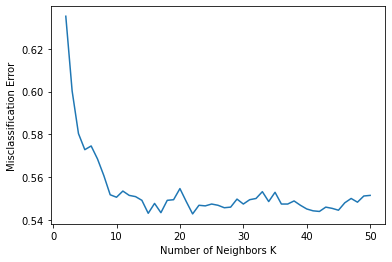

The optimal number of neighbors is 22 with score 45%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(3460, 9)
Shape of y_Train:(3460,)
Shape of X_Test:(865, 9)
Shape of y_Test:(865,)
Finding best k...


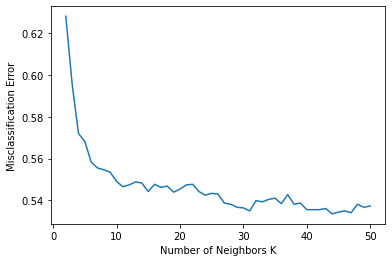

The optimal number of neighbors is 44 with score 46%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(3460, 9)
Shape of y_Train:(3460,)
Shape of X_Test:(865, 9)
Shape of y_Test:(865,)
Finding best k...


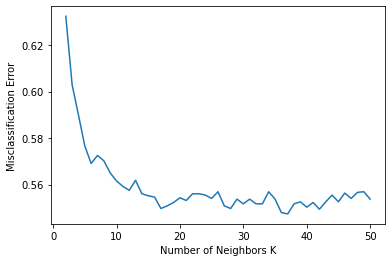

The optimal number of neighbors is 37 with score 45%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(3460, 9)
Shape of y_Train:(3460,)
Shape of X_Test:(865, 9)
Shape of y_Test:(865,)
Finding best k...


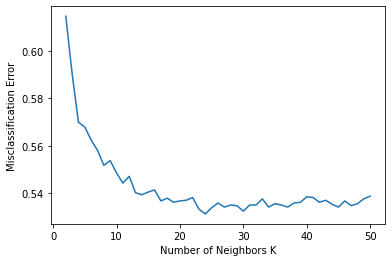

The optimal number of neighbors is 24 with score 46%


In [226]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [227]:
#results_optimal_k = [38, 33, 17, 21, 13, 46, 26, 27, 10, 26]
results_optimal_k

[22, 44, 37, 24]

## 5. Model Prediction

In [228]:
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,6IdEQ3HUseBeRUYFSzSMdL,Zebbiana,117XFtbZPnCI1EYKjYZWJc,Skusta Clee,4AaygWd1ZnCzZ4ak9EM23s,304664,2019-07-26,64,0.677,0.433,8,-8.518,1,0.0370,0.5450,0.000000,0.1050,0.498,134.006
1,6v3KW9xbzN5yKLt9YKDYA2,Señorita,7n2wHs1TKAczGzO7Dd2rGr,Shawn Mendes,0xzScN8P3hQAz3BT3YYX5w,190799,2019-06-19,82,0.759,0.548,9,-6.049,0,0.0290,0.0392,0.000000,0.0828,0.749,116.967
2,1dGr1c8CrMLDpV6mPbImSI,Lover,06HL4z0CvFAxyc27GXpf02,Taylor Swift,1NAmidJlEaVgA3MpcPFYGq,221306,2019-08-23,79,0.359,0.543,7,-7.582,1,0.0919,0.4920,0.000016,0.1180,0.453,68.534
3,0gDRtumoR9ZrvAlnniToMz,Ikaw At Ako,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,397zfeJ75BlnjfUEkgtwlG,269876,2019-01-14,64,0.445,0.355,4,-7.351,1,0.0289,0.8870,0.001790,0.3220,0.366,135.525
4,5l9g7py8RCblcvbZgGQgSd,Pagtingin,4DAcJXcjX0zlQAZAPAx4Zb,Ben&Ben,7xCcuTA3abKwxj8HwgxP7R,227370,2019-05-12,68,0.669,0.420,2,-8.464,1,0.0253,0.5060,0.000000,0.4040,0.523,95.049


In [229]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [231]:
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
               'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 24


In [232]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_chill_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_jazz_prob,predicted_opm_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob
883,61lfBHo44YaBIhAx1031CP,dear P,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,61426,2020-07-03,51,0.304,0.1540,...,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
97,6wdCelHrPh7UfliNjwRTUv,Leaves,4DAcJXcjX0zlQAZAPAx4Zb,Ben&Ben,5Yl1Bi501CuE72jaVK4e3y,310708,2017-03-31,69,0.447,0.1600,...,0.000000,0.083333,0.000000,0.0,0.833333,0.041667,0.041667,0.0,0.0,0.000000
445,6LivYvzWanzTQm8Tm3aTsa,Pasko Na Sinta Ko,0RHiqaoRCsFLPeEuj3OQz4,Gary Valenciano,1xi5bo7CCSxIVySX4dLknK,246735,1996,48,0.279,0.0824,...,0.000000,0.833333,0.000000,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.000000
504,4AQzk2yNWKs6sYhZi6NzVN,Me & You Together Song,3mIj9lX2MWuHmhNCA7LSCW,The 1975,6RicVnt1SB39xCjG81RUDo,209500,2020-01-16,62,0.272,0.7630,...,0.000000,0.000000,0.041667,0.0,0.000000,0.000000,0.083333,0.0,0.0,0.750000
961,08fa9LFcFBTcilB3iq2e2A,epiphany,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2fenSS68JI1h4Fo296JfGr,289749,2020-07-24,76,0.354,0.2670,...,0.041667,0.083333,0.000000,0.0,0.750000,0.041667,0.000000,0.0,0.0,0.083333


Check out tracks with highest assigned probability

In [233]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
883,HONNE,dear P,classical,1.000000
97,Ben&Ben,Leaves,jazz,0.833333
445,Gary Valenciano,Pasko Na Sinta Ko,classical,0.833333
504,The 1975,Me & You Together Song,rock,0.750000
961,Taylor Swift,epiphany,jazz,0.750000
549,Billie Eilish,No Time To Die,jazz,0.708333
521,Billie Eilish,when the party's over,jazz,0.708333
704,Gary Valenciano,Lead Me Lord,jazz,0.666667
407,Mariah Carey,Christmas (Baby Please Come Home),rock,0.666667
885,HONNE,loving you is so easy,rock,0.666667


View histogram of predicted genre probabilities

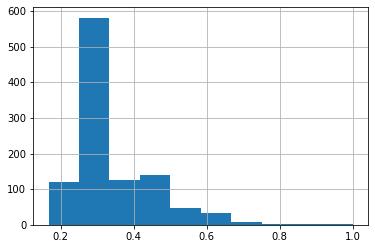

In [234]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [235]:
chart_tracks_df['predicted_genre'].value_counts()

pop            254
rock           212
country        135
jazz           134
opm             90
chill           76
rnb             63
rap             54
electronic      32
classical        8
alternative      3
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [236]:
chart_tracks_df[chart_tracks_df['track_name']=='Maybe The Night']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_chill_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_jazz_prob,predicted_opm_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob
13,1yDiru08Q6omDOGkZMPnei,Maybe The Night,4DAcJXcjX0zlQAZAPAx4Zb,Ben&Ben,6LhZ3QMHGJeTes9cCTxK8e,217197,2017-10-27,71,0.572,0.522,...,0.125,0.0,0.25,0.0,0.041667,0.041667,0.041667,0.083333,0.041667,0.333333


In [237]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Caveats
1. Using playlist names as genre tags heavily rely on *user opinion* and not *extracted music features* (compare this from the methods used in the [GTZAN genre collection dataset](https://data-flair.training/blogs/python-project-music-genre-classification/)
2. Playlists with dual genre names exists, and appear quite often in the dataset (e.g. Electronic Pop, Classical Rock)
3. Although a dominant genre could be readily observed, recent music tend to incorporate many genres at a time and thus create less distinction when the model looks at the audio features.

>Q: What other caveats could you deduce from the steps done above?


## Model Improvement
To enhance the model accuracy, try to do the following:
1. Pick "purer" top-followed playlists for the training data. A quick way to do this is to pick playlists that contain pre 2000's music as majority as these are less hybridized than more recent songs.
2. Try fewer but broader genres as categories (4-5 genres)
3. Remove outlier songs! These are the songs that dont fit its playlist's description. A bit subjective (and tedious!).
4. Limit the features used as predictors (could be inferred from the list of genres you're considering)


## Day Deliverable
*A. For your individual curiosities*
1. Choose your own set of genres to be used as prediction values of the KNN model. You may select among the ones listed above or a completely new one (but you must already have the scraped playlist and tracks data for this new genre) 

2. Choose the features you want to use for the classification. Start by using all and then narrow down by removing one feature at a time and checking if the accuracy increases.

3. Check if the model works by using it to predict genres of the spotify_daily_charts_tracks dataset. Do some spot checks and view the songs classified with the highest probabilities per genre


*B. For your sprint project*
4. Extract a tracks dataset that is relevant to the client you are targeting. 
   For example:
    - A client artist's full discography
    - Tracks from a popular playlist in spotify that your client artist appears in
    - Discographies of prospect artists to collaborate with 
    - Popular tracks of the genre that your client artist is targeting to enter
    
    
5. Using the model you tuned in (A), predict the genres of the tracks in (B.4). 

6. Do some spot checks and view the songs classified with the highest probabilities per genre. 
   What does the predicted classifications reveal about your tracks dataset?
   

